In [2]:
import json

from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import DoubleType
import pandas as  pd

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
import matplotlib as plt

# I ) - importation de données :
>> ### + La première étape consiste à importer des données à partir de l'API et à les structurer correctement.

In [4]:


# # this code scrapes the weather APIs
# url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2023-01-01&end_date=2023-12-31&hourly=temperature_2m"""
# response = requests.get(url)
# print(response)
# data_json = response.json()
# print(json.dumps(data_json, indent=4))
# # this code structures the retrieved data in a form of DataFrame.
# df_json = {}
# for  item in list(data_json['hourly_units'].keys()) :
#     df_json[item] = data_json['hourly'][item]
# df_pandas = pd.DataFrame(df_json)  
# df_pandas['time'] = pd.to_datetime(df_pandas['time'])
# df_pandas    ReadSnappyParquet

In [5]:
spark = SparkSession.builder \
    .appName("ReadSnappyParquet") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/11/29 16:39:07 WARN Utils: Your hostname, LAPTOP-DN3PCHGN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/29 16:39:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/29 16:39:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
# Path to the .snappy.parquet file or directory
parquet_path = "/home/hoan123/Time-Series-Forecasting-Spark-Kafka-for-Weather-Data-main/delta_lake/delta_lake_table_3"

# Read the .snappy.parquet files
df = spark.read.parquet(parquet_path)

# Display the content
df.show()



+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      0.0|       Partly cloudy|
|2024-10-18 08:00:00|Hanoi|Vietnam| 21.0333|   105.85|  27.5|     4.3|    77.0|      0.2|   Light rain shower|
|2024-10-18 09:00:00|Hanoi|Vietnam| 21.0333|   105.85|  29.2|     4.9|    69.0|     0.06|Patchy rain possible|
|2024-10-18 10:00:00|Hanoi|Vietnam| 21.0333|   105.85|  30.7|     5.1|    62.0|     0.29|   Light rain shower|
|

In [14]:
df_pandas = df.toPandas() 

In [15]:
df = df.select("datetime", "temp_c")
df.show()

+-------------------+------+
|           datetime|temp_c|
+-------------------+------+
|2024-10-18 05:00:00|  25.0|
|2024-10-18 06:00:00|  24.9|
|2024-10-18 07:00:00|  25.9|
|2024-10-18 08:00:00|  27.5|
|2024-10-18 09:00:00|  29.2|
|2024-10-18 10:00:00|  30.7|
|2024-10-18 11:00:00|  31.7|
|2024-10-18 12:00:00|  32.4|
|2024-10-18 13:00:00|  31.8|
|2024-10-18 14:00:00|  31.5|
|2024-10-18 15:00:00|  31.4|
|2024-10-18 16:00:00|  30.7|
|2024-10-18 17:00:00|  29.9|
|2024-10-18 18:00:00|  28.6|
|2024-10-18 19:00:00|  27.7|
|2024-10-18 20:00:00|  27.1|
|2024-10-18 21:00:00|  26.6|
|2024-10-18 22:00:00|  26.3|
|2024-10-18 23:00:00|  26.0|
|2024-10-19 00:00:00|  25.4|
+-------------------+------+
only showing top 20 rows



>> ### - Ensuite, nous devons convertir les données extraites en un DataFrame Spark, afin de pouvoir les traiter librement et entraîner les modèles d'apprentissage automatique.

In [16]:
# Create a Spark session
spark = SparkSession.builder.appName("example").config("spark.executor.memory", "4g").config("spark.driver.memory", "7g").getOrCreate()
# df = spark.createDataFrame(df)

24/11/29 16:44:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# II) - exploration de données

> ## 1) - Exploreration des valeurs manquantes

In [17]:
# Check for null values in each column
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"Null values in column '{column}': {null_count}")

Null values in column 'datetime': 0
Null values in column 'temp_c': 0


> ## 2) - visualisation de l'évolution des températures sur les 4 dernières années

In [18]:
# sampled_df = df.select("datetime", "temp_c").limit(3000)

# # Chuyển đổi Spark DataFrame sang Pandas DataFrame
# pandas_df = sampled_df.toPandas()

# # Chuyển đổi cột 'datetime' sang định dạng datetime của Pandas
# pandas_df['datetime'] = pd.to_datetime(pandas_df['datetime'])

# # Vẽ biểu đồ
# plt.figure(figsize=(12, 6))
# plt.plot(pandas_df['datetime'], pandas_df['temp_c'], color='blue', label='Temperature (°C)')

# # Tùy chỉnh biểu đồ
# plt.xlabel('Datetime')
# plt.ylabel('Temperature (°C)')
# plt.title('Temperature Over Time')
# plt.grid(True)
# plt.legend()
# plt.xticks(rotation=45)  # Xoay trục x để dễ đọc hơn
# plt.tight_layout()

# # Hiển thị biểu đồ
# plt.show()

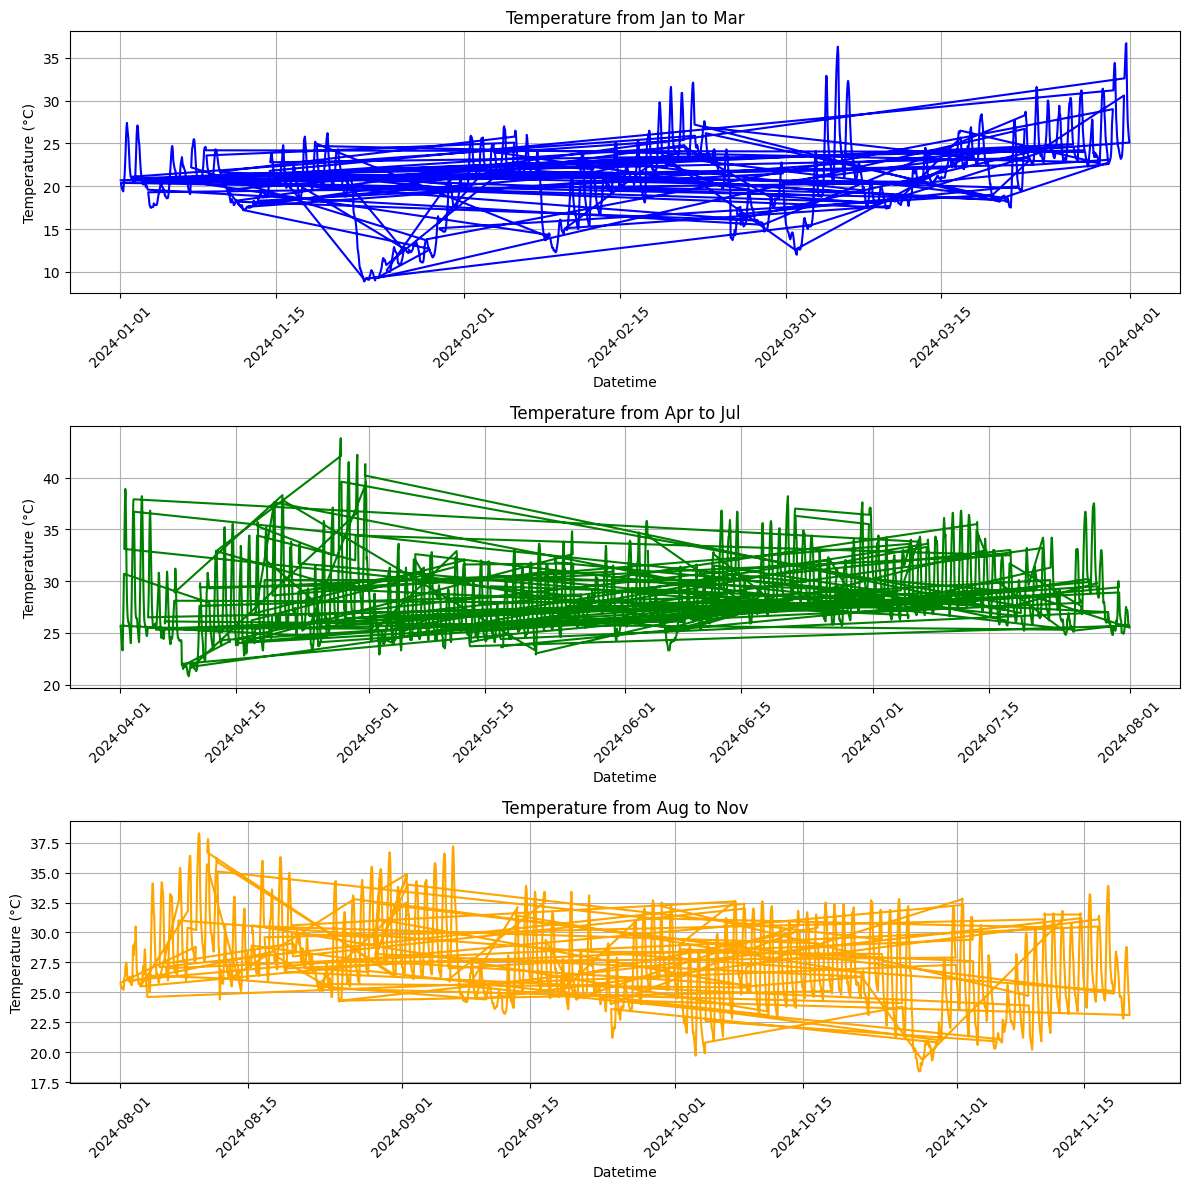

In [19]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import month

# Chia dữ liệu thành 3 khoảng thời gian
data_jan_mar = df.filter((month("datetime") >= 1) & (month("datetime") <= 3))
data_apr_jul = df.filter((month("datetime") >= 4) & (month("datetime") <= 7))
data_aug_nov = df.filter((month("datetime") >= 8) & (month("datetime") <= 11))

# Chuyển từng tập dữ liệu sang Pandas
data_jan_mar_pd = data_jan_mar.toPandas()
data_apr_jul_pd = data_apr_jul.toPandas()
data_aug_nov_pd = data_aug_nov.toPandas()

# Vẽ các biểu đồ
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)

# Biểu đồ cho tháng 1-3
axes[0].plot(data_jan_mar_pd['datetime'], data_jan_mar_pd['temp_c'], color="blue")
axes[0].set_title("Temperature from Jan to Mar")
axes[0].set_xlabel("Datetime")
axes[0].set_ylabel("Temperature (°C)")

# Biểu đồ cho tháng 4-7
axes[1].plot(data_apr_jul_pd['datetime'], data_apr_jul_pd['temp_c'], color="green")
axes[1].set_title("Temperature from Apr to Jul")
axes[1].set_xlabel("Datetime")
axes[1].set_ylabel("Temperature (°C)")

# Biểu đồ cho tháng 8-11
axes[2].plot(data_aug_nov_pd['datetime'], data_aug_nov_pd['temp_c'], color="orange")
axes[2].set_title("Temperature from Aug to Nov")
axes[2].set_xlabel("Datetime")
axes[2].set_ylabel("Temperature (°C)")

# Tùy chỉnh đồ thị
for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()


In [20]:
# limited_data

> ## 2) - visualisation de l'évolution des températures pour l'année en cours

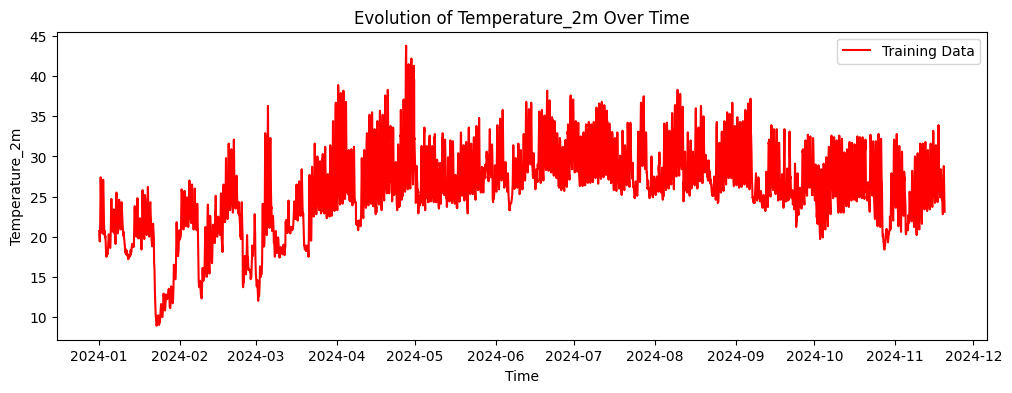

In [21]:
df = df.orderBy('datetime')
plt.figure(figsize=(12, 4))
plt.plot(df.select('datetime').rdd.flatMap(lambda x: x).collect()[-9000:], df.select('temp_c').rdd.flatMap(lambda x: x).collect()[-9000:], color='red', label='Training Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

# III) - feature Engineering : indexation chronologique
> ## 1) - maintenant, nous allons supprimer toutes les colonnes sauf « temps » et « température ».
>> - variable explicable : température.
>> - variable explicative : temps

In [22]:
# Select only the "time" and "assembled_features" columns
df = df.select("datetime", "temp_c")
df.show()

+-------------------+------+
|           datetime|temp_c|
+-------------------+------+
|2024-01-01 00:00:00|  20.7|
|2024-01-01 01:00:00|  20.4|
|2024-01-01 02:00:00|  20.0|
|2024-01-01 03:00:00|  19.8|
|2024-01-01 04:00:00|  19.6|
|2024-01-01 05:00:00|  19.6|
|2024-01-01 06:00:00|  19.4|
|2024-01-01 07:00:00|  20.0|
|2024-01-01 08:00:00|  20.5|
|2024-01-01 09:00:00|  21.3|
|2024-01-01 10:00:00|  22.5|
|2024-01-01 11:00:00|  23.9|
|2024-01-01 12:00:00|  25.7|
|2024-01-01 13:00:00|  26.9|
|2024-01-01 14:00:00|  27.4|
|2024-01-01 15:00:00|  26.7|
|2024-01-01 16:00:00|  26.2|
|2024-01-01 17:00:00|  25.6|
|2024-01-01 18:00:00|  24.6|
|2024-01-01 19:00:00|  23.4|
+-------------------+------+
only showing top 20 rows



> ## 2) - Si nous avons besoin de créer un modèle capable de prédire la température du futur, nous devons entraîner ce modèle sur des données ne contenant que des indices temporels. Ainsi, nous pourrons le former à cartographier la relation entre le temps et la variable cible. Pour ce faire, nous allons utiliser le script suivant.

In [23]:
data = df
df = (df
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)
df.show()

+-------------------+------+----+----+-----+-------+-----------+------------+-----------+
|           datetime|temp_c|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+------+----+----+-----+-------+-----------+------------+-----------+
|2024-01-01 00:00:00|  20.7|   0|   1|    1|      1|          2|           1|          1|
|2024-01-01 01:00:00|  20.4|   1|   1|    1|      1|          2|           1|          1|
|2024-01-01 02:00:00|  20.0|   2|   1|    1|      1|          2|           1|          1|
|2024-01-01 03:00:00|  19.8|   3|   1|    1|      1|          2|           1|          1|
|2024-01-01 04:00:00|  19.6|   4|   1|    1|      1|          2|           1|          1|
|2024-01-01 05:00:00|  19.6|   5|   1|    1|      1|          2|           1|          1|
|2024-01-01 06:00:00|  19.4|   6|   1|    1|      1|          2|           1|          1|
|2024-01-01 07:00:00|  20.0|   7|   1|    1|      1|          2|           1|          1|
|2024-01-0

> ## 3) -  la normalisation des  columns  :
>> #### La normalisation des données est cruciale pour garantir que toutes les caractéristiques contribuent équitablement aux modèles d'apprentissage automatique. Cela permet d'éviter que des variables avec des échelles différentes ne dominent l'apprentissage du modèle.







In [24]:
data = df 

In [25]:
# Select columns to normalize
columns_to_normalize = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']
for col_name in columns_to_normalize:
    min_value = df.agg({col_name: 'min'}).collect()[0][0]
    max_value = df.agg({col_name: 'max'}).collect()[0][0]
    normalized_column = col_name + '_normalized'
    df = df.withColumn(normalized_column, (col(col_name) - min_value) / (max_value - min_value))
    df = df.drop(col_name).withColumnRenamed(normalized_column, col_name)

In [26]:
df.show()

+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+
|           datetime|temp_c|                hour|week|month|quarter|        day_of_week|day_of_month|day_of_year|
+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+
|2024-01-01 00:00:00|  20.7|                 0.0| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 01:00:00|  20.4|0.043478260869565216| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 02:00:00|  20.0| 0.08695652173913043| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 03:00:00|  19.8| 0.13043478260869565| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 04:00:00|  19.6| 0.17391304347826086| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 05:00:00|  19.6| 0.21739130434782608| 0.0|  0.0|    0.0|0.16666666666666666|

In [27]:
data = df

# IV) - Entraînement et évaluation des modèles.
> ### Dans cette section, nous allons essayer d'Entraîner plusieurs modèles sur nos données et choisir le modèle le plus performant

In [56]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
def display_model_performance(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    # Convert the PySpark DataFrame to a Pandas DataFrame
    result_df = predictions.select("label", "prediction").toPandas()

    # Plot the graph
    plt.plot(result_df['label'], result_df['prediction'], 'bo')
    plt.xlabel('Temperature')
    plt.ylabel('Prediction')
    plt.suptitle("Model Performance RMSE: %f" % rmse)
    plt.show()
    

def evaluate_model(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data)
    forecast_bias = predictions.agg(F.avg(predictions['label'] - predictions['prediction'])).collect()[0][0]

    # Calculate R-squared (R2)
    evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
    r2 = evaluator.evaluate(predictions)

    # Calculate Mean Absolute Scaled Error (MASE)
    mean_absolute_error = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})
    mase = mean_absolute_error / predictions.agg(F.mean('label')).collect()[0][0]

    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    smape_numerator = F.sum(F.abs(predictions['label'] - predictions['prediction']))
    smape_denominator = F.sum(F.abs(predictions['label']) + F.abs(predictions['prediction']))
    smape = F.when(smape_denominator == 0, 0).otherwise(200 * smape_numerator / smape_denominator)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = F.avg(F.abs(predictions['label'] - predictions['prediction']) / F.abs(predictions['label']))

    # Calculate Root Mean Squared Error (RMSE)
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})

    # Calculate Mean Squared Error (MSE)
    mse = evaluator.evaluate(predictions, {evaluator.metricName: 'mse'})

    # Calculate Mean Absolute Error (MAE)
    mae = evaluator.evaluate(predictions, {evaluator.metricName: 'mae'})

    # Print the metrics
    print(f"Forecast Bias: {forecast_bias}")
    print(f"R-squared (R2): {r2}")
    print(f"Mean Absolute Scaled Error (MASE): {mase}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return [ forecast_bias , r2 , mase , rmse , mse , mae ]
#  [ 'Forecast Bias' , 'R-squared (R2)' , 'Mean Absolute Scaled Error (MASE)' , 'Root Mean Squared Error (RMSE)','Mean Squared Error (MSE)' , 'Mean Absolute Error (MAE)']


In [57]:
data = df 
df = df.drop('time')

In [58]:
from pyspark.ml.feature import VectorAssembler
feature_list = []
df = df.withColumnRenamed("temp_c", "label")
for col in df.columns:
    if col == 'temp_c':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [59]:
# Sort the data based on 'time'
df = df.orderBy('datetime')

> ## 1) - Construction et entrainement du modèle Random Forest Regressor.

>>> ### a) Construction du model 

In [60]:
feature_cols = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']  # Các feature không có 'datetime'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [61]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[assembler, rf])

In [62]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 20, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 10, num = 3)]) \
    .build()

In [63]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [64]:
from pyspark.sql.functions import col, to_timestamp

df = data.withColumnRenamed('temp_c', 'label')
df = df.withColumn("datetime", to_timestamp("datetime"))
trainingData = df.filter(col('datetime') < '2024-10-01 12:00:00').drop('datetime')
testData = df.filter(col('datetime') >= '2024-10-01 12:00:00').drop('datetime')
trainingData = trainingData.withColumn("label", trainingData["label"].cast(DoubleType()))
testData = testData.withColumn("label", testData["label"].cast(DoubleType()))

testData.show(10)

+-----+------------------+------------------+-----+-------+------------------+------------+-----------------+
|label|              hour|              week|month|quarter|       day_of_week|day_of_month|      day_of_year|
+-----+------------------+------------------+-----+-------+------------------+------------+-----------------+
| 29.0|0.5217391304347826|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 28.5|0.5652173913043478|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 28.0|0.6086956521739131|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 27.1|0.6521739130434783|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 25.9|0.6956521739130435|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 25.1|0.7391304347826086|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 24.3| 0.

In [65]:
trainingData = trainingData.withColumn("label", trainingData["label"].cast(DoubleType()))
testData = testData.withColumn("label", testData["label"].cast(DoubleType()))

In [66]:
trainingData

DataFrame[label: double, hour: double, week: double, month: double, quarter: double, day_of_week: double, day_of_month: double, day_of_year: double]

>>> ### b) Entrainement du model 

In [67]:
cvModel = crossval.fit(trainingData)

24/11/29 17:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
24/11/29 17:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1485.9 KiB
24/11/29 17:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1249.9 KiB
24/11/29 17:06:21 WARN DAGScheduler: Broadcasting large task binary with size 1926.4 KiB
24/11/29 17:07:00 WARN DAGScheduler: Broadcasting large task binary with size 1061.6 KiB
24/11/29 17:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1516.2 KiB
24/11/29 17:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1266.7 KiB
24/11/29 17:08:06 WARN DAGScheduler: Broadcasting large task binary with size 1951.9 KiB
24/11/29 17:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
24/11/29 17:09:15 WARN DAGScheduler: Broadcasting large task binary with size 1485.9 KiB
24/11/29 17:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1273.0 KiB
24/11/29 17:09:49 WAR

>>> ### c) Prediction du model 

In [72]:
predictions = cvModel.transform(testData)
predictions

DataFrame[label: double, hour: double, week: double, month: double, quarter: double, day_of_week: double, day_of_month: double, day_of_year: double, features: vector, prediction: double]

In [73]:
testData.show(5)  # Check the first few rows of testData


+-----+------------------+------------------+-----+-------+------------------+------------+-----------------+
|label|              hour|              week|month|quarter|       day_of_week|day_of_month|      day_of_year|
+-----+------------------+------------------+-----+-------+------------------+------------+-----------------+
| 29.0|0.5217391304347826|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 28.5|0.5652173913043478|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 28.0|0.6086956521739131|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 27.1|0.6521739130434783|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
| 25.9|0.6956521739130435|0.8478260869565217|  0.9|    1.0|0.3333333333333333|         0.0|0.848297213622291|
+-----+------------------+------------------+-----+-------+------------------+------------+-----------------+
only showi

>>> ### d) évaluation des performances du modèle

In [74]:
models_performance = []
models_performance.append(['RandomForestRegressor']+evaluate_model(cvModel, testData))

Forecast Bias: -0.6563540232057662
R-squared (R2): 0.22519070874517677
Mean Absolute Scaled Error (MASE): 0.08727730274484864
Root Mean Squared Error (RMSE): 3.0542285144912977
Mean Squared Error (MSE): 9.32831181873172
Mean Absolute Error (MAE): 2.2621057340130095


>>> ### d) Analyse de l'importance des variables explicatives pour la prédiction

In [75]:
def display_feature_importances(model, feature_cols):
    # Truy cập model bên trong pipeline
    rf_model = model.bestModel.stages[-1]  # Assuming RandomForestRegressor là stage cuối trong pipeline
    importances = rf_model.featureImportances.toArray()
    
    # Gắn feature importances với tên các feature
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: -x[1])
    
    print("Feature Importances:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")

    # Optional: Plot feature importances
    import matplotlib.pyplot as plt
    feature_names = [f[0] for f in feature_importance]
    scores = [f[1] for f in feature_importance]
    plt.barh(feature_names, scores, color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()


In [76]:
# Danh sách các cột features
feature_cols = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']


Feature Importances:
week: 0.3814
hour: 0.1617
day_of_year: 0.1387
day_of_month: 0.1380
quarter: 0.0799
month: 0.0733
day_of_week: 0.0270


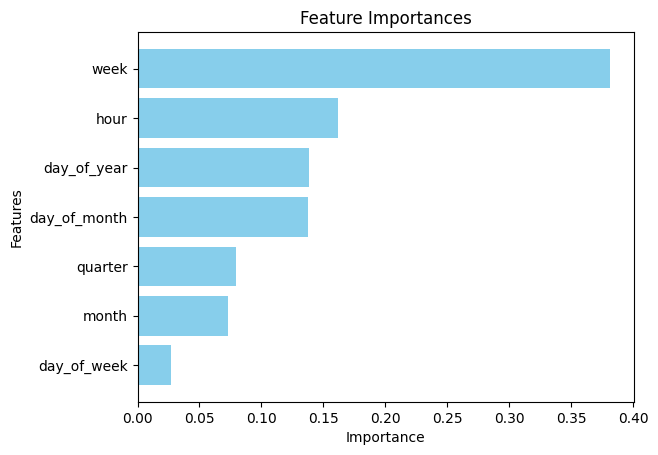

In [77]:
display_feature_importances(cvModel, feature_cols)

>>> ### e) - analyse la cohérence entre la température prévue et la température réelle

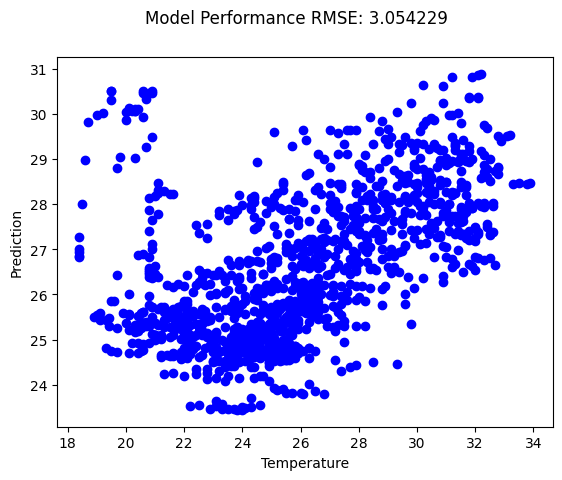

In [78]:
display_model_performance(cvModel, testData)

        Feature  Importance
1          week    0.381389
0          hour    0.161723
6   day_of_year    0.138722
5  day_of_month    0.137955
3       quarter    0.079891
2         month    0.073308
4   day_of_week    0.027011


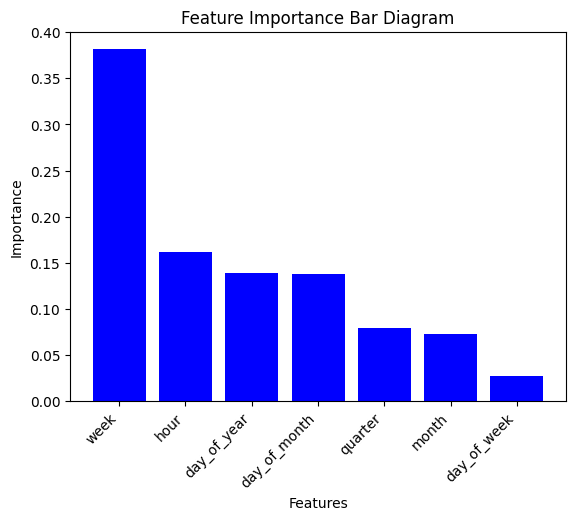

In [81]:
# Extract feature importances from the trained RandomForestRegressor model
feature_importances = cvModel.bestModel.stages[-1].featureImportances
feature_importance_df = pd.DataFrame({
    'Feature': assembler.getInputCols(),
    'Importance': feature_importances.toArray()
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

importance = list(feature_importance_df.Importance )[:]
Feature = list(feature_importance_df.Feature )[:]

plt.bar(Feature, importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Bar Diagram')
plt.xticks(rotation=45, ha='right')
plt.show()

In [83]:
# Save the model to a folder
cvModel.save("models/random_forest_model2")

In [ ]:
pip install requests

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 KB 1.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 KB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests

In [ ]:
# this code scrapes the weather APIs
url = """https://archive-api.open-meteo.com/v1/era5?latitude=52.52&longitude=13.41&start_date=2024-01-01&end_date=2024-03-15&hourly=temperature_2m"""
response = requests.get(url)
print(response)
data_json = response.json()
print(json.dumps(data_json, indent=4))
# this code structures the retrieved data in a form of DataFrame.
df_json = {}
for  item in list(data_json['hourly_units'].keys()) :
    df_json[item] = data_json['hourly'][item]
df_pandas = pd.DataFrame(df_json)  
df_pandas['time'] = pd.to_datetime(df_pandas['time'])
df_pandas    

<Response [200]>
{
    "latitude": 52.54833,
    "longitude": 13.407822,
    "generationtime_ms": 0.10609626770019531,
    "utc_offset_seconds": 0,
    "timezone": "GMT",
    "timezone_abbreviation": "GMT",
    "elevation": 38.0,
    "hourly_units": {
        "time": "iso8601",
        "temperature_2m": "\u00b0C"
    },
    "hourly": {
        "time": [
            "2024-01-01T00:00",
            "2024-01-01T01:00",
            "2024-01-01T02:00",
            "2024-01-01T03:00",
            "2024-01-01T04:00",
            "2024-01-01T05:00",
            "2024-01-01T06:00",
            "2024-01-01T07:00",
            "2024-01-01T08:00",
            "2024-01-01T09:00",
            "2024-01-01T10:00",
            "2024-01-01T11:00",
            "2024-01-01T12:00",
            "2024-01-01T13:00",
            "2024-01-01T14:00",
            "2024-01-01T15:00",
            "2024-01-01T16:00",
            "2024-01-01T17:00",
            "2024-01-01T18:00",
            "2024-01-01T19:00",
    

,time,temperature_2m
0,2024-01-01 00:00:00,5.0
1,2024-01-01 01:00:00,5.4
2,2024-01-01 02:00:00,5.1
3,2024-01-01 03:00:00,4.7
4,2024-01-01 04:00:00,4.4
...,...,...
1795,2024-03-15 19:00:00,11.4
1796,2024-03-15 20:00:00,11.2
1797,2024-03-15 21:00:00,10.4
1798,2024-03-15 22:00:00,10.5


In [ ]:
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline

# Try loading as a PipelineModel first
try:
    loaded_model = PipelineModel.load("models/random_forest_model/bestModel")
except Exception as e:
    print("Failed to load as PipelineModel, trying Pipeline...")
    try:
        loaded_model = Pipeline.load("models/random_forest_model/bestModel")
    except Exception as e2:
        print("Both loading methods failed.")
        print("PipelineModel error:", e)
        print("Pipeline error:", e2)
        raise e2

# Once loaded, convert your data if needed
if isinstance(df_pandas, pd.DataFrame):
    spark_df = spark.createDataFrame(df_pandas)
else:
    spark_df = df_pandas
feature_list = []
spark_df = spark_df.withColumnRenamed("temperature_2m", "label")
for col in spark_df.columns:
    if col == 'temperature_2m':
        continue
    else:
        feature_list.append(col)
df = spark_df
df = (df
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)
df.show()
from pyspark.sql.functions import col, to_timestamp

columns_to_normalize = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']
for col_name in columns_to_normalize:
    min_value = df.agg({col_name: 'min'}).collect()[0][0]
    max_value = df.agg({col_name: 'max'}).collect()[0][0]
    normalized_column = col_name + '_normalized'
    df = df.withColumn(normalized_column, (col(col_name) - min_value) / (max_value - min_value))
    df = df.drop(col_name).withColumnRenamed(normalized_column, col_name)
df = data.withColumnRenamed('temperature_2m', 'label')
df = df.withColumn("time", to_timestamp("time"))


+-------------------+-----+----+----+-----+-------+-----------+------------+-----------+
|               time|label|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----+----+----+-----+-------+-----------+------------+-----------+
|2024-01-01 00:00:00|  5.0|   0|   1|    1|      1|          2|           1|          1|
|2024-01-01 01:00:00|  5.4|   1|   1|    1|      1|          2|           1|          1|
|2024-01-01 02:00:00|  5.1|   2|   1|    1|      1|          2|           1|          1|
|2024-01-01 03:00:00|  4.7|   3|   1|    1|      1|          2|           1|          1|
|2024-01-01 04:00:00|  4.4|   4|   1|    1|      1|          2|           1|          1|
|2024-01-01 05:00:00|  3.9|   5|   1|    1|      1|          2|           1|          1|
|2024-01-01 06:00:00|  3.8|   6|   1|    1|      1|          2|           1|          1|
|2024-01-01 07:00:00|  3.5|   7|   1|    1|      1|          2|           1|          1|
|2024-01-01 08:00:00|

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `time` cannot be resolved. Did you mean one of the following? [`week`, `datetime`, `hour`, `temp_c`, `month`].;
'Project [datetime#0, temp_c#5, hour#238, week#300, month#362, quarter#424, day_of_week#486, day_of_month#548, day_of_year#610, to_timestamp('time, None, TimestampType, Some(Asia/Bangkok), false) AS time#3195]
+- Project [datetime#0, temp_c#5, hour#238, week#300, month#362, quarter#424, day_of_week#486, day_of_month#548, day_of_year_normalized#590 AS day_of_year#610]
   +- Project [datetime#0, temp_c#5, hour#238, week#300, month#362, quarter#424, day_of_week#486, day_of_month#548, day_of_year_normalized#590]
      +- Project [datetime#0, temp_c#5, day_of_year#139, hour#238, week#300, month#362, quarter#424, day_of_week#486, day_of_month#548, (cast((day_of_year#139 - 1) as double) / cast(323 as double)) AS day_of_year_normalized#590]
         +- Project [datetime#0, temp_c#5, day_of_year#139, hour#238, week#300, month#362, quarter#424, day_of_week#486, day_of_month_normalized#528 AS day_of_month#548]
            +- Project [datetime#0, temp_c#5, day_of_year#139, hour#238, week#300, month#362, quarter#424, day_of_week#486, day_of_month_normalized#528]
               +- Project [datetime#0, temp_c#5, day_of_month#130, day_of_year#139, hour#238, week#300, month#362, quarter#424, day_of_week#486, (cast((day_of_month#130 - 1) as double) / cast(30 as double)) AS day_of_month_normalized#528]
                  +- Project [datetime#0, temp_c#5, day_of_month#130, day_of_year#139, hour#238, week#300, month#362, quarter#424, day_of_week_normalized#466 AS day_of_week#486]
                     +- Project [datetime#0, temp_c#5, day_of_month#130, day_of_year#139, hour#238, week#300, month#362, quarter#424, day_of_week_normalized#466]
                        +- Project [datetime#0, temp_c#5, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week#300, month#362, quarter#424, (cast((day_of_week#122 - 1) as double) / cast(6 as double)) AS day_of_week_normalized#466]
                           +- Project [datetime#0, temp_c#5, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week#300, month#362, quarter_normalized#404 AS quarter#424]
                              +- Project [datetime#0, temp_c#5, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week#300, month#362, quarter_normalized#404]
                                 +- Project [datetime#0, temp_c#5, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week#300, month#362, (cast((quarter#115 - 1) as double) / cast(3 as double)) AS quarter_normalized#404]
                                    +- Project [datetime#0, temp_c#5, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week#300, month_normalized#342 AS month#362]
                                       +- Project [datetime#0, temp_c#5, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week#300, month_normalized#342]
                                          +- Project [datetime#0, temp_c#5, month#109, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week#300, (cast((month#109 - 1) as double) / cast(10 as double)) AS month_normalized#342]
                                             +- Project [datetime#0, temp_c#5, month#109, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week_normalized#280 AS week#300]
                                                +- Project [datetime#0, temp_c#5, month#109, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, week_normalized#280]
                                                   +- Project [datetime#0, temp_c#5, week#104, month#109, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour#238, (cast((week#104 - 1) as double) / cast(46 as double)) AS week_normalized#280]
                                                      +- Project [datetime#0, temp_c#5, week#104, month#109, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour_normalized#218 AS hour#238]
                                                         +- Project [datetime#0, temp_c#5, week#104, month#109, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, hour_normalized#218]
                                                            +- Project [datetime#0, temp_c#5, hour#100, week#104, month#109, quarter#115, day_of_week#122, day_of_month#130, day_of_year#139, (cast((hour#100 - 0) as double) / cast(23 as double)) AS hour_normalized#218]
                                                               +- Project [datetime#0, temp_c#5, hour#100, week#104, month#109, quarter#115, day_of_week#122, day_of_month#130, dayofyear(cast(datetime#0 as date)) AS day_of_year#139]
                                                                  +- Project [datetime#0, temp_c#5, hour#100, week#104, month#109, quarter#115, day_of_week#122, dayofmonth(cast(datetime#0 as date)) AS day_of_month#130]
                                                                     +- Project [datetime#0, temp_c#5, hour#100, week#104, month#109, quarter#115, dayofweek(cast(datetime#0 as date)) AS day_of_week#122]
                                                                        +- Project [datetime#0, temp_c#5, hour#100, week#104, month#109, quarter(cast(datetime#0 as date)) AS quarter#115]
                                                                           +- Project [datetime#0, temp_c#5, hour#100, week#104, month(cast(datetime#0 as date)) AS month#109]
                                                                              +- Project [datetime#0, temp_c#5, hour#100, weekofyear(cast(datetime#0 as date)) AS week#104]
                                                                                 +- Project [datetime#0, temp_c#5, hour(datetime#0, Some(Asia/Bangkok)) AS hour#100]
                                                                                    +- Project [datetime#0, temp_c#5]
                                                                                       +- Sort [datetime#0 ASC NULLS FIRST], true
                                                                                          +- Project [datetime#0, temp_c#5]
                                                                                             +- Relation [datetime#0,name#1,country#2,latitude#3,longitude#4,temp_c#5,wind_mph#6,humidity#7,precip_mm#8,condition#9] parquet


In [ ]:
# Make predictions
predictions = loaded_model.transform(df)
predictions.show()

+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+--------------------+------------------+
|           datetime|temp_c|                hour|week|month|quarter|        day_of_week|day_of_month|day_of_year|            features|        prediction|
+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+--------------------+------------------+
|2024-01-01 00:00:00|  20.7|                 0.0| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|(7,[4],[0.1666666...|20.638481311640188|
|2024-01-01 01:00:00|  20.4|0.043478260869565216| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|(7,[0,4],[0.04347...|20.638481311640188|
|2024-01-01 02:00:00|  20.0| 0.08695652173913043| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|(7,[0,4],[0.08695...|20.638481311640188|
|2024-01-01 03:00:00|  19.8| 0.13043478260869565| 0.0|  0.0|    0.0|0.166666

In [ ]:
df.show(5)

+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+
|           datetime|temp_c|                hour|week|month|quarter|        day_of_week|day_of_month|day_of_year|
+-------------------+------+--------------------+----+-----+-------+-------------------+------------+-----------+
|2024-01-01 00:00:00|  20.7|                 0.0| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 01:00:00|  20.4|0.043478260869565216| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 02:00:00|  20.0| 0.08695652173913043| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 03:00:00|  19.8| 0.13043478260869565| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
|2024-01-01 04:00:00|  19.6| 0.17391304347826086| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|
+-------------------+------+--------------------+----+-----+-------+-------------------+